In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# 显示图片的函数
def cv_show(name,img):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
# 显示彩色图片的函数
def plt_show0(img):
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    plt.figure(dpi=200)
    plt.imshow(img)
    plt.show()
    
# 显示灰度图片的函数
def plt_show(img):
    plt.figure(dpi=100)
    plt.imshow(img,cmap='gray')
    plt.show()

In [3]:
# 裁剪完成后进行分割
def image_cut(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #从上到下，从左到右，不写就是原始的上下左右边界。带 - 号的是从右边或者从下开始计算距离，-10指切去右边缘长度为10的margin
    img = img[:, :-10, :]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 43, 46])
    upper_blue = np.array([124, 255, 255])
    #mask：两个阈值内的变白，其他的变黑，返回一个二值化的图像
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
#     plt_show(mask)
    img_morph = mask.copy()
    # 腐蚀膨胀，中值滤波
    core = (3, 3)
    cv2.erode(img_morph, core, img_morph, iterations=4)
    cv2.dilate(img_morph, core, img_morph, iterations=1)
    img_morph = cv2.medianBlur(img_morph, 15)
    res = cv2.findContours(img_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnts = res[0] #cnts就是提取到的所有contours组成的list
    # sort the elements in contours by the area of a contour, descending order
    cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
    # 生成一个与img相同shape的全0数组white_img
    white_img = np.zeros_like(img)
#     plt_show0(white_img)
    white_img[:, :, :] = 0 #变成一张纯黑的图
    # 第三个参数0代表：绘制cnts_sort里的第一个contour
    # 最后一个参数-1代表：绘制contour时，填充轮廓内部
    cv2.drawContours(white_img, cnts_sort, 0, (255, 255, 255), -1) #会在白底上画出黑色的区域
#     plt_show0(white_img)
    black_img = np.zeros_like(img)
    black_img[:, :, :] = 255 #变成一张纯白的图
#     plt_show0(black_img)
    black_img_copy = cv2.cvtColor(black_img, cv2.COLOR_BGR2GRAY)#变成了一张纯黑的图
#     plt_show(black_img_copy)
    cv2.drawContours(black_img_copy, cnts_sort, 0, (0, 0, 0), -1) #这里的颜色只要不是(255, 255, 255)，就都是白色；(255, 255, 255)画出黑色
#     cv2.imwrite('black_img.png', black_img_copy)
#     plt_show(black_img_copy)
    res = cv2.findContours(black_img_copy, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

#     cv2.imwrite('black_img.png', black_img_copy)
    img_copy = img.copy()
    cv2.drawContours(img_copy, res[0][0], -1, (0, 255, 0), 10)
#     cv2.imwrite('img_copy.png', img_copy)
    plt_show0(img_copy)
    x, y, w, h = cv2.boundingRect(res[0][0])
    pure_img = img.copy()
    # 获得方框
    cv2.rectangle(pure_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
#     cv2.imwrite('pure_img.png', pure_img)
#     plt_show0(pure_img)
    ## 灰度图
    gray_pure_img = cv2.cvtColor(pure_img, cv2.COLOR_BGR2GRAY)
#     cv2.imwrite('gray_pure_img.png', gray_pure_img)
#     plt_show(gray_pure_img)
    # 裁剪
    cuted_image = img[y:y + h, x:x + w]
#     cv2.imwrite('cuted_image.png', cuted_image)
    plt_show0(cuted_image)
    bounding = res[0][0] # 最大的contour
    
    #让contour的所有点的坐标移动，以配合裁剪出来的新图片
    def bounding_move(bounding_point):
        bounding_point[0, 0] -= x #裁剪范围的左上角的x坐标
        bounding_point[0, 1] -= y
        return bounding_point

    bounding = np.array(list(map(bounding_move, bounding)))
    return cuted_image, bounding

In [4]:
def fill_black(image, bounding):
    stencil = np.zeros(image.shape).astype(image.dtype)
    color = (255, 255, 255)
    cv2.fillPoly(stencil, [bounding], color)
    result = cv2.bitwise_and(image, stencil)
    return result

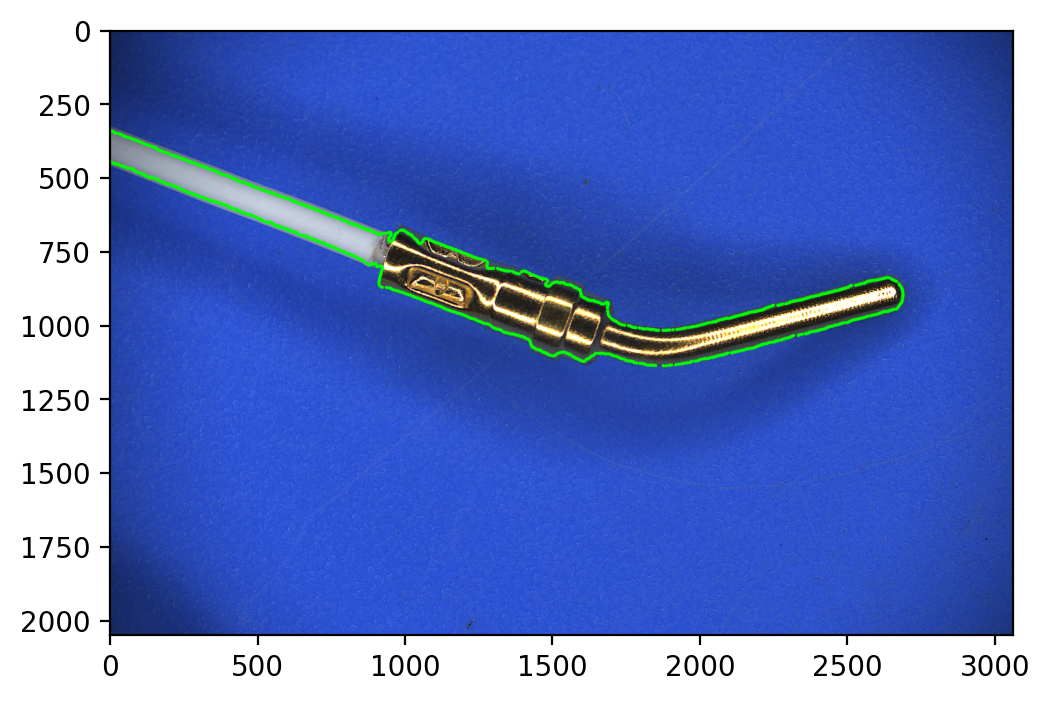

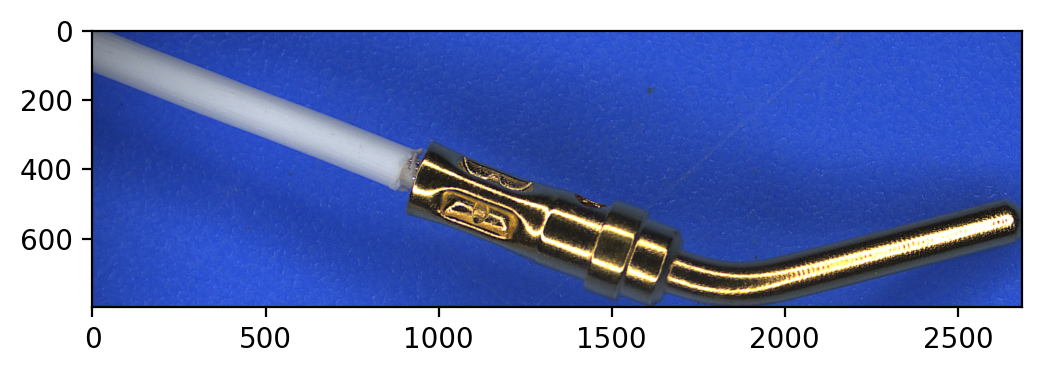

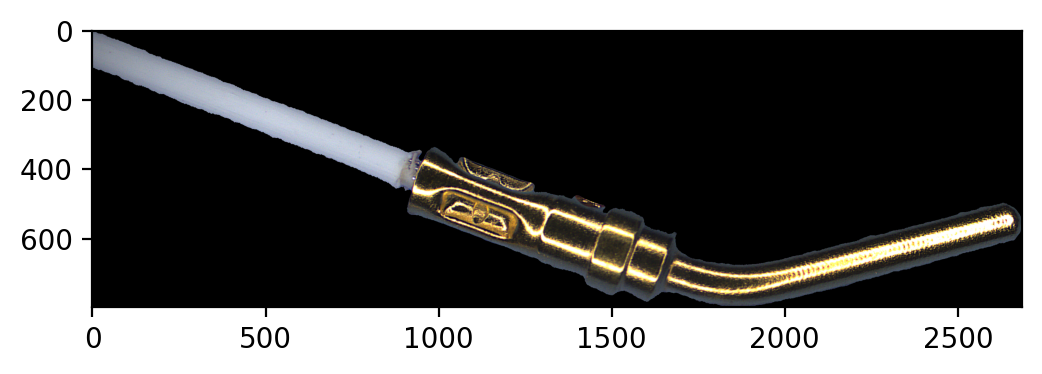

In [6]:
#改一下这里
img_dir = r"/Users/zhouxinyu/论文:电子资料/项目/电缆ZF项目/数据/Image/线筒弯曲 (5).tif"
cuted_image, bounding = image_cut(image_path=img_dir)
fill_black = fill_black(cuted_image, bounding)
# cv2.imwrite('fill_black.png', fill_black)
plt_show0(fill_black)

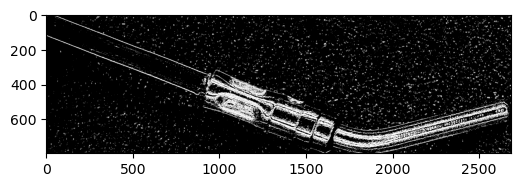

922


In [7]:
#rawImage = cv2.imread("F:/python/tubeBending/tubeBendingImage/tif/test01.tif")
rawImage = cuted_image

# 高斯去噪
image = cv2.GaussianBlur(rawImage, (3,3), 0)

#灰度处理
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#sobel算子边缘检测（做了一个x方向的检测）
Sobel_y = cv2.Sobel(gray_image, cv2.CV_16S, 0, 1)
# 转回unit8
absY = cv2.convertScaleAbs(Sobel_y)

# image = absX
image = absY
image_copy = absY
# plt_show(image)

ret, image = cv2.threshold(image,30,255,cv2.THRESH_BINARY)
plt_show(image)

height, width = image.shape
xPosition = -1
combo2 = 0
for x in range(0,width,2):
    combo = 0
    for y in range(0, height):
        if image[y][x] == 255:
#             print("y=",y,"x=",x,"  ",image[y][x])
            combo += 1
        else:
            combo = 0
        if combo == 9:
            break
    if combo == 9:
        combo2 += 1
    else:
        combo2 = 0
    if combo2 == 3:
        xPosition = x
        break

print(xPosition)

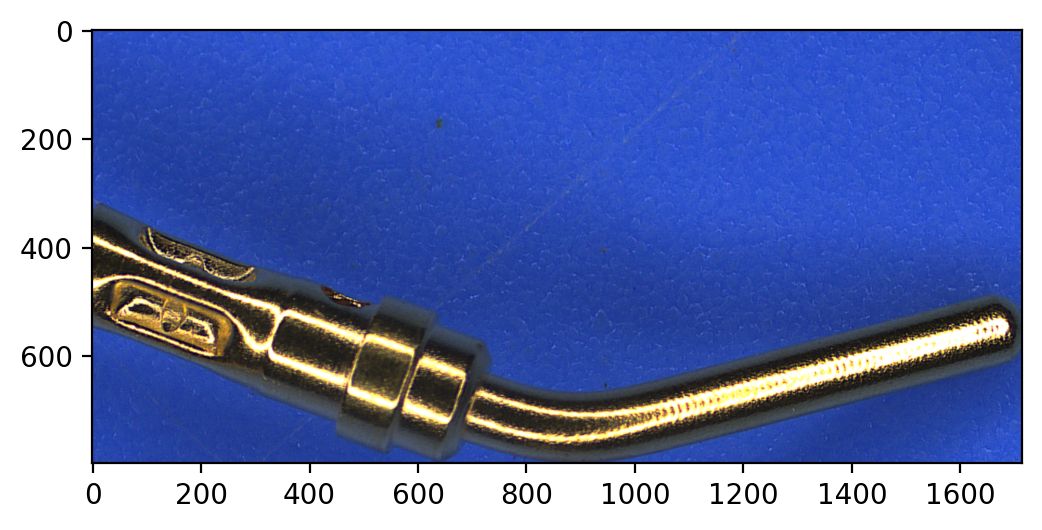

In [8]:
margin = 50
height, width, color = cuted_image.shape
imageLRight = cuted_image[0:height,xPosition+margin:width]
plt_show0(imageLRight)

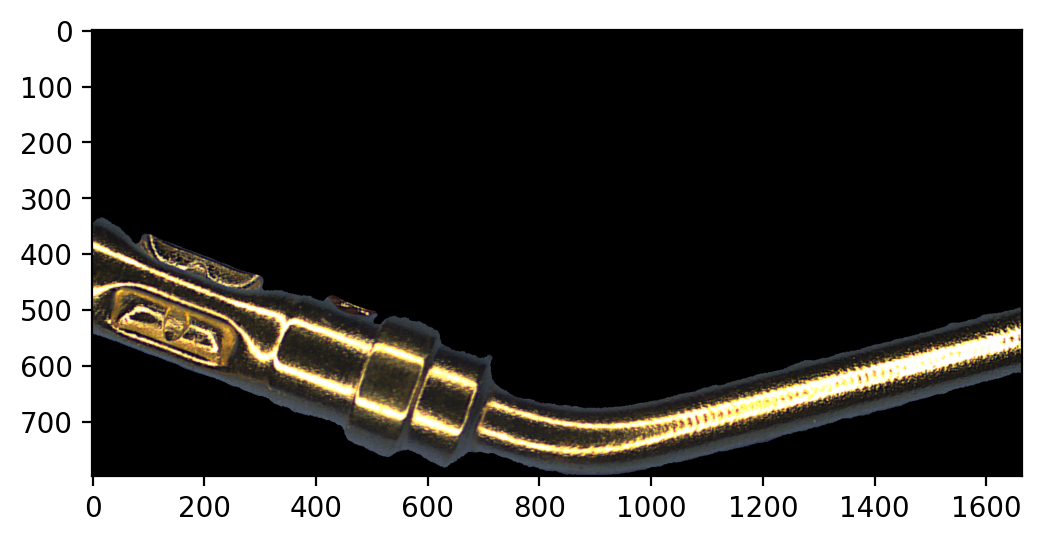

In [9]:
height, width, color = fill_black.shape
fill_black_right = fill_black[0:height,xPosition+margin:width-margin]
plt_show0(fill_black_right)

In [11]:
height, width, color = fill_black_right.shape
fill_black_right_HSV = cv2.cvtColor(fill_black_right, cv2.COLOR_BGR2HSV)

# left 1 ---------------------------------------
left_1 = []
left_1_middle_y = 0
left_1_start_x = width//20
left_1_end_x = width//10
for x in range(100,200,5):
     for y in range(0, height):
        if fill_black_right_HSV[y][x][2] != 0:
            left_1.append((x,y))
            left_1_middle_y += y
            break

# print(left_1)
left_1_middle_x = (left_1_start_x + left_1_end_x)//2
left_1_middle_y = left_1_middle_y/(len(left_1))
print(left_1_middle_x,left_1_middle_y)

#left 2 ------------------------------------------
left_2 = []
left_2_middle_y = 0
left_2_start_x = 3 * width//20
left_2_end_x = width//5
for x in range(left_2_start_x,left_2_end_x,5):
     for y in range(0, height):
        if fill_black_right_HSV[y][x][2] != 0:
            left_2.append((x,y))
            left_2_middle_y += y
            break

# print(left_1)
left_2_middle_x = (left_2_start_x + left_2_end_x)//2
left_2_middle_y = left_2_middle_y/(len(left_2))
print(left_2_middle_x,left_2_middle_y)


#right 1 ------------------------------------------
right_1 = []
right_1_middle_y = 0
right_1_start_x = width - width//5
right_1_end_x = width - 3 * width//20
for x in range(right_1_start_x,right_1_end_x,5):
     for y in range(0, height):
        if fill_black_right_HSV[y][x][2] != 0:
            right_1.append((x,y))
            right_1_middle_y += y
            break

right_1_middle_x = (right_1_start_x + right_1_end_x)//2
right_1_middle_y = right_1_middle_y/(len(right_1))
print(right_1_middle_x,right_1_middle_y)

#right 2 ------------------------------------------
right_2 = []
right_2_middle_y = 0
right_2_start_x = width - width//10
right_2_end_x = width - width//20
for x in range(right_2_start_x,right_2_end_x,5):
     for y in range(0, height):
        if fill_black_right_HSV[y][x][2] != 0:
            right_2.append((x,y))
            right_2_middle_y += y
            break

right_2_middle_x = (right_2_start_x + right_2_end_x)//2
right_2_middle_y = right_2_middle_y/(len(right_2))
print(right_2_middle_x,right_2_middle_y)
            

124 383.1
291 441.94117647058823
1374 570.0
1540 526.2352941176471


In [12]:
def vector_angle(line1: list, line2: list):
    """
    计算两条直线的夹角，
    :param line1: 直线一[x1, y1, x2, y2]
    :param line2: 直线二 [x1, y1, x2, y2]
    :return:
    """

    vector1 = np.array([line1[2] - line1[0], line1[3] - line1[1]])  # (x2-x1,y2-y1)
    vector2 = np.array([line2[2] - line2[0], line2[3] - line2[1]])
    return np.arccos(
        vector1 @ vector2 / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))

In [13]:
line1 = [left_1_middle_x,left_1_middle_y, left_2_middle_x,left_2_middle_y]
line2 = [right_1_middle_x,right_1_middle_y, right_2_middle_x,right_2_middle_y]
a = vector_angle(line1,line2)
print(a)
pi = 3.1415926
print("result: ",a/pi*180,"°")


0.5965372073056183
result:  34.17906488416458 °
